In [21]:
# Convierte el excel a csv
import pandas as pd

def excel_a_csv(ruta_excel, ruta_csv):
    # Lee el archivo Excel
    df = pd.read_excel(ruta_excel)
    
    # Guarda el DataFrame como un archivo CSV
    df.to_csv(ruta_csv, index=False)

if __name__ == "__main__":
    ruta_excel = "precios_historicos.xlsx"
    ruta_csv = "precios_historicos.csv"
    excel_a_csv(ruta_excel, ruta_csv)
    print(f"Archivo convertido de {ruta_excel} a {ruta_csv}")



Archivo convertido de precios_historicos.xlsx a precios_historicos.csv


In [22]:
df_resultados = pd.read_csv("precios_historicos.csv")
df_resultados

,Date,NVDA.O,AAPL.O,LMT,MSFT.O,SIEGn.DE eur,SIEGn.DE Usd,GOOGL.O,INTC.O,EUR=
0,2025-11-25,177.82,276.97,452.41,476.99,227.00,262.616300,323.44,35.83,1.1569
1,2025-11-24,182.55,275.92,451.06,474.00,223.00,256.896000,318.58,35.79,1.1520
2,2025-11-21,178.88,271.49,460.78,472.12,219.15,252.263565,299.66,34.50,1.1511
3,2025-11-20,180.64,266.25,468.26,478.43,221.10,254.861970,289.45,33.62,1.1527
4,2025-11-19,186.52,268.56,469.91,487.12,218.60,252.176960,292.81,35.11,1.1536
...,...,...,...,...,...,...,...,...,...,...
1051,2021-08-27,22.64,148.60,361.99,299.72,140.68,NaN,144.00,53.89,1.1793
1052,2021-08-26,22.07,147.54,361.62,299.09,139.06,NaN,141.44,53.13,1.1750
1053,2021-08-25,22.21,148.36,358.75,302.01,138.94,NaN,142.08,53.81,1.1770
1054,2021-08-24,21.79,149.62,359.00,302.62,140.14,NaN,141.26,53.81,1.1753


# Instrucciones 1

Quiero que en base mi csv hagas lo siguiente:

El dataframe df_precios tiene más de mil días de los price close de las acciones de mis empresas de mi portafolio (NVDA.O, AAPL.O, LMT, MSFT.O, SIEGn.DE, GOOGL.O, INTC.O) [SIEGn.De eur es versión usd porque cotiza en euros y todo el portafolio debe de ser en usd, tmb EUR= es el cambio de euro a dólar y lo multiplique en excel entonces se ignora]. Quiero que calcules el VaR Parametrico, VaR no Parametrico para z de confianza de 95% y 99%. Saca los valores del VaR en dolarés y en porcentajes. El detalle es que saques todo esto desde 8/9/2025 a 23/8/2021, que se supone que deberían de ser mil días (mil datos), porque quiero calcular todo con márgenes de mil días históricos. Ahora, hay más días en mi csv, esto porque quiero que lo calcules de nuevo para el siguiente día respetando los mil días, es decir luego se calcula desde 9/9/2025 a 24/8/2021  y así hasta la fecha más actual. 

Como se sacan los VaR? Bueno, para una ventana de mil días se hace así:
Para sacar los valores V0 lo que quiero hacer es multiplicar cada precio de cada empresa por la cantidad de acciones (V0=precio_de_accion*cantidad_de_acciones+...+precio_de_accion*cantidad_de_acciones). El P&L se calcula con restando el v0 de un dia anterior al dia actual (serian 999 porque el dia actual no tiene el dia de mañana). El ranked P&L es meramente ordenarlo de valor más chico a más grande del P&L. El rendimiento es el v0actual/v0ayer-1 o algo asi segun yo es (esto para cada fila de la tabla que igual serian 999).

Saca las variables de rendimiento promedio (prom de la columna rendimiento) y desviación estandar del rendimiento (desv de la columna rendimiento)

Para calcular el VaR Parametrico en excel lo hice más o menos así pero adaptalo para mi trabajo
El 1 day 1% VaR se calcula: =v0_hoy * (2.326 * rendimiento_promedio-desviación_estandar_del_rendimiento)
El 1 day 5% VaR se calcula: =v0_hoy * (1.645 * rendimiento_promedio-desviación_estandar_del_rendimiento)

Para calcular el VaR no Parametrico en excel lo hice más o menos así pero adaptalo para mi trabajo
El 1 day 1% VaR se calcula: =ABS(BUSCARV(MAX($B$2:$B$1001)*0.01,$B$2:$N$1001,10,0))
El 1 day 5% VaR se calcula: =ABS(BUSCARV(MAX($B$2:$B$1001)*0.05,$B$2:$N$1001,10,0))
donde $B$2:$N$1001 es toda la matriz de los costos (12 costos de acciones de las empresas + columna de los dias de 1 a 1000), y $B$2:$B$1001 es solamente la columna de los dias (de 1 a 1000), y el numero 10 se refiere a la columna del ranked P&L.





In [23]:
# Cálculo de VaR Paramétrico y No Paramétrico con ventana rodante de 1000 días
import pandas as pd
import numpy as np

# Cargar datos
df = pd.read_csv("precios_historicos.csv")
print(f"Total de filas en el CSV: {len(df)}")
print(f"Primeras fechas: {df['Date'].head()}")
print(f"Últimas fechas: {df['Date'].tail()}")

# Las 7 empresas del portafolio (en USD)
empresas = ['NVDA.O', 'AAPL.O', 'LMT', 'MSFT.O', 'SIEGn.DE Usd', 'GOOGL.O', 'INTC.O']

# IMPORTANTE: Define aquí las cantidades de acciones de cada empresa
# Ejemplo (modifica estos valores según tu portafolio):
cantidades_acciones = {
    'NVDA.O': 1892,
    'AAPL.O': 528,
    'LMT': 217,
    'MSFT.O': 200,
    'SIEGn.DE Usd': 369,
    'GOOGL.O': 381,
    'INTC.O': 1436
}

print(f"\nCantidades de acciones por empresa:")
for empresa, cantidad in cantidades_acciones.items():
    print(f"  {empresa}: {cantidad} acciones")

Total de filas en el CSV: 1056
Primeras fechas: 0    2025-11-25
1    2025-11-24
2    2025-11-21
3    2025-11-20
4    2025-11-19
Name: Date, dtype: object
Últimas fechas: 1051    2021-08-27
1052    2021-08-26
1053    2021-08-25
1054    2021-08-24
1055    2021-08-23
Name: Date, dtype: object

Cantidades de acciones por empresa:
  NVDA.O: 1892 acciones
  AAPL.O: 528 acciones
  LMT: 217 acciones
  MSFT.O: 200 acciones
  SIEGn.DE Usd: 369 acciones
  GOOGL.O: 381 acciones
  INTC.O: 1436 acciones


In [24]:
# Función para calcular VaR para una ventana de 1000 días
def calcular_var_ventana(df_ventana, cantidades, fecha_actual):
    """
    Calcula VaR Paramétrico y No Paramétrico para una ventana de 1000 días
    """
    # Asegurar que tenemos exactamente 1000 días
    if len(df_ventana) != 1000:
        return None
    
    # Calcular V0 para cada día (valor del portafolio)
    v0_list = []
    for idx in range(len(df_ventana)):
        v0 = 0
        for empresa in empresas:
            precio = df_ventana.iloc[idx][empresa]
            v0 += precio * cantidades[empresa]
        v0_list.append(v0)
    
    # Calcular P&L (999 valores, desde día 1 hasta día 999 comparando con día siguiente)
    pl_list = []
    for i in range(len(v0_list) - 1):
        pl = v0_list[i+1] - v0_list[i]
        pl_list.append(pl)
    
    # Calcular rendimientos (999 valores)
    rendimientos = []
    for i in range(len(v0_list) - 1):
        rendimiento = (v0_list[i+1] / v0_list[i]) - 1
        rendimientos.append(rendimiento)
    
    # Estadísticas de rendimiento
    rendimiento_promedio = np.mean(rendimientos)
    desv_std_rendimiento = np.std(rendimientos, ddof=1)  # Desviación estándar muestral
    
    # V0 del día actual (último día de la ventana, índice 999)
    v0_hoy = v0_list[-1]
    
    # VaR Paramétrico
    # 99% confianza (1% cola izquierda) -> z = 2.326
    # 95% confianza (5% cola izquierda) -> z = 1.645
    var_parametrico_99 = v0_hoy * (2.326 * desv_std_rendimiento - rendimiento_promedio )
    var_parametrico_95 = v0_hoy * (1.645 * desv_std_rendimiento - rendimiento_promedio )
    
    # VaR No Paramétrico
    # Ranked P&L (ordenar de menor a mayor)
    ranked_pl = sorted(pl_list)
    
    # Percentil 1% (para 99% confianza) y 5% (para 95% confianza)
    # Con 999 observaciones:
    # 1% de 999 = 9.99 ≈ posición 10 (índice 9)
    # 5% de 999 = 49.95 ≈ posición 50 (índice 49)
    indice_1pct = int(0.01 * len(ranked_pl))
    indice_5pct = int(0.05 * len(ranked_pl))
    
    var_no_parametrico_99 = abs(ranked_pl[indice_1pct])
    var_no_parametrico_95 = abs(ranked_pl[indice_5pct])
    
    # VaR en porcentaje del portafolio
    var_parametrico_99_pct = (var_parametrico_99 / v0_hoy) * 100
    var_parametrico_95_pct = (var_parametrico_95 / v0_hoy) * 100
    var_no_parametrico_99_pct = (var_no_parametrico_99 / v0_hoy) * 100
    var_no_parametrico_95_pct = (var_no_parametrico_95 / v0_hoy) * 100
    
    return {
        'Fecha': fecha_actual,
        'V0': v0_hoy,
        'Rendimiento_Promedio': rendimiento_promedio,
        'Desv_Std_Rendimiento': desv_std_rendimiento,
        'VaR_Parametrico_99_USD': var_parametrico_99,
        'VaR_Parametrico_95_USD': var_parametrico_95,
        'VaR_No_Parametrico_99_USD': var_no_parametrico_99,
        'VaR_No_Parametrico_95_USD': var_no_parametrico_95,
        'VaR_Parametrico_99_Pct': var_parametrico_99_pct,
        'VaR_Parametrico_95_Pct': var_parametrico_95_pct,
        'VaR_No_Parametrico_99_Pct': var_no_parametrico_99_pct,
        'VaR_No_Parametrico_95_Pct': var_no_parametrico_95_pct
    }

print("Función de cálculo de VaR definida.")

Función de cálculo de VaR definida.


In [25]:
# Aplicar la ventana rodante de 1000 días
resultados = []

# El CSV tiene los datos ordenados de más reciente a más antiguo
# Necesitamos invertir para tener cronológico (más antiguo primero)
df_ordenado = df.iloc[::-1].reset_index(drop=True)

print(f"Datos ordenados cronológicamente:")
print(f"  Primera fecha (más antigua): {df_ordenado.iloc[0]['Date']}")
print(f"  Última fecha (más reciente): {df_ordenado.iloc[-1]['Date']}")
print(f"  Total de días: {len(df_ordenado)}")

# Calcular cuántas ventanas de 1000 días podemos hacer
num_ventanas = len(df_ordenado) - 999
print(f"\nNúmero de ventanas de 1000 días a calcular: {num_ventanas}")

# Iterar sobre cada ventana posible
for i in range(num_ventanas):
    # Tomar ventana de 1000 días (índices i hasta i+999)
    df_ventana = df_ordenado.iloc[i:i+1000]
    
    # Fecha del día actual (último día de la ventana)
    fecha_actual = df_ventana.iloc[-1]['Date']
    
    # Calcular VaR para esta ventana
    resultado = calcular_var_ventana(df_ventana, cantidades_acciones, fecha_actual)
    
    if resultado:
        resultados.append(resultado)
    
    # Mostrar progreso cada 10 ventanas
    if (i + 1) % 10 == 0:
        print(f"  Procesadas {i + 1}/{num_ventanas} ventanas...")

print(f"\nCálculos completados. Total de resultados: {len(resultados)}")

Datos ordenados cronológicamente:
  Primera fecha (más antigua): 2021-08-23
  Última fecha (más reciente): 2025-11-25
  Total de días: 1056

Número de ventanas de 1000 días a calcular: 57


  Procesadas 10/57 ventanas...
  Procesadas 20/57 ventanas...
  Procesadas 20/57 ventanas...
  Procesadas 30/57 ventanas...
  Procesadas 30/57 ventanas...
  Procesadas 40/57 ventanas...
  Procesadas 40/57 ventanas...
  Procesadas 50/57 ventanas...
  Procesadas 50/57 ventanas...

Cálculos completados. Total de resultados: 57

Cálculos completados. Total de resultados: 57


In [26]:
# Crear DataFrame con los resultados
df_var_resultados = pd.DataFrame(resultados)

# Mostrar primeros resultados
print("\n" + "="*80)
print("PRIMEROS RESULTADOS DE VaR")
print("="*80)
print(df_var_resultados.head(10))

# Mostrar últimos resultados
print("\n" + "="*80)
print("ÚLTIMOS RESULTADOS DE VaR")
print("="*80)
print(df_var_resultados.tail(10))


PRIMEROS RESULTADOS DE VaR
        Fecha             V0  Rendimiento_Promedio  Desv_Std_Rendimiento  \
0  2025-09-08  867738.755570                   NaN                   NaN   
1  2025-09-09  870774.504900                   NaN                   NaN   
2  2025-09-10  881228.896280                   NaN                   NaN   
3  2025-09-11  885099.490685                   NaN                   NaN   
4  2025-09-12  889552.546835                   NaN                   NaN   
5  2025-09-15  898374.888800                   NaN                   NaN   
6  2025-09-16  892308.493170                   NaN                   NaN   
7  2025-09-17  882051.865700                   NaN                   NaN   
8  2025-09-18  902592.185200                   NaN                   NaN   
9  2025-09-19  908600.782240                   NaN                   NaN   

   VaR_Parametrico_99_USD  VaR_Parametrico_95_USD  VaR_No_Parametrico_99_USD  \
0                     NaN                     NaN      

In [27]:
# Resumen estadístico de los VaR calculados
print("\n" + "="*80)
print("RESUMEN ESTADÍSTICO DE LOS VaR")
print("="*80)
print("\nVaR en USD:")
print(df_var_resultados[['VaR_Parametrico_99_USD', 'VaR_Parametrico_95_USD', 
                          'VaR_No_Parametrico_99_USD', 'VaR_No_Parametrico_95_USD']].describe())

print("\n\nVaR en Porcentaje:")
print(df_var_resultados[['VaR_Parametrico_99_Pct', 'VaR_Parametrico_95_Pct', 
                          'VaR_No_Parametrico_99_Pct', 'VaR_No_Parametrico_95_Pct']].describe())


RESUMEN ESTADÍSTICO DE LOS VaR

VaR en USD:
       VaR_Parametrico_99_USD  VaR_Parametrico_95_USD  \
count               28.000000               28.000000   
mean             32228.767723            22545.466982   
std                812.312745              560.099859   
min              31210.004846            21834.053779   
25%              31583.977962            22092.146435   
50%              31921.250767            22340.289095   
75%              32807.191886            22944.227252   
max              33758.300102            23598.091352   

       VaR_No_Parametrico_99_USD  VaR_No_Parametrico_95_USD  
count                  37.000000                  57.000000  
mean                26206.388290               13484.852254  
std                  5320.328526                1500.866004  
min                 23841.673270               12094.101114  
25%                 23841.673270               12264.591248  
50%                 23841.673270               12744.142180  
75%    

In [28]:
# Guardar resultados en CSV
archivo_salida = "resultados_var_rolling_1000dias.csv"
df_var_resultados.to_csv(archivo_salida, index=False)
print(f"\n✓ Resultados guardados en: {archivo_salida}")

# Mostrar información sobre el archivo guardado
print(f"\nColumnas guardadas:")
for col in df_var_resultados.columns:
    print(f"  - {col}")
print(f"\nTotal de filas guardadas: {len(df_var_resultados)}")


✓ Resultados guardados en: resultados_var_rolling_1000dias.csv

Columnas guardadas:
  - Fecha
  - V0
  - Rendimiento_Promedio
  - Desv_Std_Rendimiento
  - VaR_Parametrico_99_USD
  - VaR_Parametrico_95_USD
  - VaR_No_Parametrico_99_USD
  - VaR_No_Parametrico_95_USD
  - VaR_Parametrico_99_Pct
  - VaR_Parametrico_95_Pct
  - VaR_No_Parametrico_99_Pct
  - VaR_No_Parametrico_95_Pct

Total de filas guardadas: 57


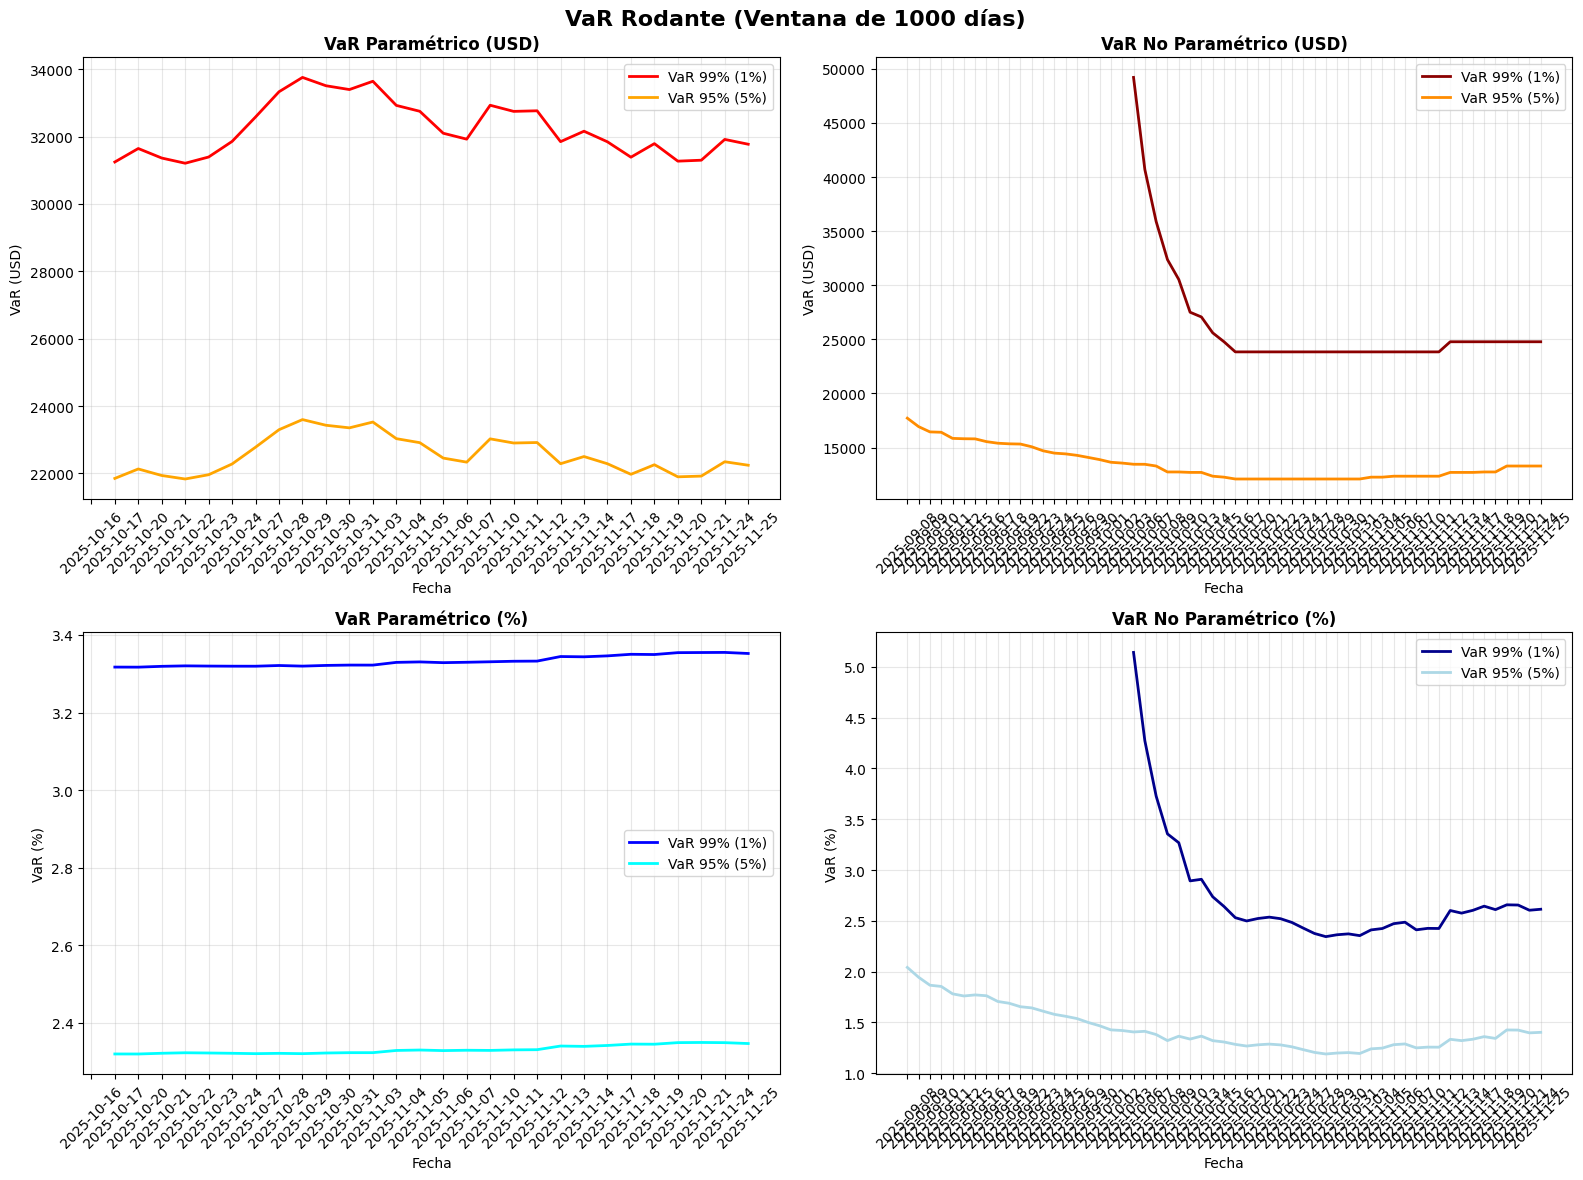

In [29]:
# Visualización de los resultados
import matplotlib.pyplot as plt

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('VaR Rodante (Ventana de 1000 días)', fontsize=16, fontweight='bold')

# VaR Paramétrico en USD
axes[0, 0].plot(df_var_resultados['Fecha'], df_var_resultados['VaR_Parametrico_99_USD'], 
                label='VaR 99% (1%)', linewidth=2, color='red')
axes[0, 0].plot(df_var_resultados['Fecha'], df_var_resultados['VaR_Parametrico_95_USD'], 
                label='VaR 95% (5%)', linewidth=2, color='orange')
axes[0, 0].set_title('VaR Paramétrico (USD)', fontweight='bold')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('VaR (USD)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# VaR No Paramétrico en USD
axes[0, 1].plot(df_var_resultados['Fecha'], df_var_resultados['VaR_No_Parametrico_99_USD'], 
                label='VaR 99% (1%)', linewidth=2, color='darkred')
axes[0, 1].plot(df_var_resultados['Fecha'], df_var_resultados['VaR_No_Parametrico_95_USD'], 
                label='VaR 95% (5%)', linewidth=2, color='darkorange')
axes[0, 1].set_title('VaR No Paramétrico (USD)', fontweight='bold')
axes[0, 1].set_xlabel('Fecha')
axes[0, 1].set_ylabel('VaR (USD)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# VaR Paramétrico en Porcentaje
axes[1, 0].plot(df_var_resultados['Fecha'], df_var_resultados['VaR_Parametrico_99_Pct'], 
                label='VaR 99% (1%)', linewidth=2, color='blue')
axes[1, 0].plot(df_var_resultados['Fecha'], df_var_resultados['VaR_Parametrico_95_Pct'], 
                label='VaR 95% (5%)', linewidth=2, color='cyan')
axes[1, 0].set_title('VaR Paramétrico (%)', fontweight='bold')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('VaR (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# VaR No Paramétrico en Porcentaje
axes[1, 1].plot(df_var_resultados['Fecha'], df_var_resultados['VaR_No_Parametrico_99_Pct'], 
                label='VaR 99% (1%)', linewidth=2, color='darkblue')
axes[1, 1].plot(df_var_resultados['Fecha'], df_var_resultados['VaR_No_Parametrico_95_Pct'], 
                label='VaR 95% (5%)', linewidth=2, color='lightblue')
axes[1, 1].set_title('VaR No Paramétrico (%)', fontweight='bold')
axes[1, 1].set_xlabel('Fecha')
axes[1, 1].set_ylabel('VaR (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [30]:
df_var_resultados

,Fecha,V0,Rendimiento_Promedio,Desv_Std_Rendimiento,VaR_Parametrico_99_USD,VaR_Parametrico_95_USD,VaR_No_Parametrico_99_USD,VaR_No_Parametrico_95_USD,VaR_Parametrico_99_Pct,VaR_Parametrico_95_Pct,VaR_No_Parametrico_99_Pct,VaR_No_Parametrico_95_Pct
0,2025-09-08,8.677388e+05,NaN,NaN,NaN,NaN,NaN,17716.682062,NaN,NaN,NaN,2.041707
1,2025-09-09,8.707745e+05,NaN,NaN,NaN,NaN,NaN,16932.649602,NaN,NaN,NaN,1.944550
2,2025-09-10,8.812289e+05,NaN,NaN,NaN,NaN,NaN,16447.089050,NaN,NaN,NaN,1.866381
3,2025-09-11,8.850995e+05,NaN,NaN,NaN,NaN,NaN,16413.189940,NaN,NaN,NaN,1.854389
4,2025-09-12,8.895525e+05,NaN,NaN,NaN,NaN,NaN,15847.416502,NaN,NaN,NaN,1.781504
5,2025-09-15,8.983749e+05,NaN,NaN,NaN,NaN,NaN,15814.437758,NaN,NaN,NaN,1.760338
6,2025-09-16,8.923085e+05,NaN,NaN,NaN,NaN,NaN,15802.614042,NaN,NaN,NaN,1.770981
7,2025-09-17,8.820519e+05,NaN,NaN,NaN,NaN,NaN,15547.266674,NaN,NaN,NaN,1.762625
8,2025-09-18,9.025922e+05,NaN,NaN,NaN,NaN,NaN,15401.623210,NaN,NaN,NaN,1.706377
9,2025-09-19,9.086008e+05,NaN,NaN,NaN,NaN,NaN,15344.938636,NaN,NaN,NaN,1.688854


## 📊 Instrucciones para Ejecutar

**IMPORTANTE:** Antes de ejecutar las celdas, debes modificar las cantidades de acciones en la primera celda de código.

### Pasos:
1. **Modifica el diccionario `cantidades_acciones`** en la primera celda de código con las cantidades reales de tu portafolio
2. **Ejecuta todas las celdas en orden** (puedes usar "Run All" desde el menú)
3. Los resultados se guardarán automáticamente en `resultados_var_rolling_1000dias.csv`

### Qué hace el código:
- ✅ Calcula **VaR Paramétrico** (99% y 95% confianza) usando distribución normal
- ✅ Calcula **VaR No Paramétrico** (99% y 95% confianza) usando percentiles históricos
- ✅ Usa una **ventana rodante de 1000 días** para cada cálculo
- ✅ Calcula VaR en **dólares** y en **porcentaje** del valor del portafolio
- ✅ Genera gráficas para visualizar la evolución del VaR en el tiempo

### Columnas en el resultado:
- `Fecha`: Fecha del día actual de cada ventana
- `V0`: Valor total del portafolio en USD
- `Rendimiento_Promedio`: Promedio de rendimientos en la ventana
- `Desv_Std_Rendimiento`: Desviación estándar de rendimientos
- `VaR_Parametrico_99_USD` y `VaR_Parametrico_95_USD`: VaR paramétrico en dólares
- `VaR_No_Parametrico_99_USD` y `VaR_No_Parametrico_95_USD`: VaR no paramétrico en dólares
- `VaR_Parametrico_99_Pct` y `VaR_Parametrico_95_Pct`: VaR paramétrico en porcentaje
- `VaR_No_Parametrico_99_Pct` y `VaR_No_Parametrico_95_Pct`: VaR no paramétrico en porcentaje